In [42]:
from tensorflow.keras.datasets import reuters
import pandas as pd
import numpy as np
import time

import os
from dotenv import load_dotenv
from sklearn.preprocessing import LabelEncoder

from utils.utils import TopicNeuralNet
pd.set_option('display.max_colwidth', None)

## Import data

In [43]:
path = "./data/"

In [44]:
df = pd.read_csv(path+"/4.tagged_reviews_sample_verified.csv")

In [45]:
hold_out_index = df["app"]== "com.binance.dev"

In [46]:
df_holdout = df[hold_out_index].copy()
df_r = df[~hold_out_index].copy()

In [47]:
df_r = df_r.sample(df_r.shape[0] * 100, replace=True)

In [48]:
df_r.shape

(21100, 17)

In [49]:
df_r["gemini_llm_topic"].value_counts()

gemini_llm_topic
Usability/UI/UX                     3582
Reliability/Stability               3422
Account Management                  3146
Customer Support                    3050
Transaction Fees/Speed              2790
Generic feedback                    2009
Verification/KYC/AML Processes      1400
Features/Functionality               690
Educational Resources/Onboarding     409
Security                             397
Wallet Security/Integration          109
Privacy                               96
Name: count, dtype: int64

## Preprocessing

In [50]:
from collections import Counter
import string
import nltk

In [51]:
#nlp = spacy.load('en_core_web_sm')
#nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words("english")
stemmer = nltk.stem.PorterStemmer()

In [52]:
def nltk_tokenizer(doc):
    doc = doc.strip()
    doc = doc.lower()
    tokens = nltk.word_tokenize(doc)
    return [stemmer.stem(t) for t in tokens if \
        t not in string.punctuation and \
        t not in stopwords ] #only consider alphanumeric character

In [53]:
df_r["content_preprocessed"] = df_r["content"].apply(lambda x: " ".join(nltk_tokenizer(x)))

In [54]:
df_r["content_preprocessed"].head()

238                                                                                                                                                                                                      puzzl hunt ca n't claim reward 's wast peopl like bought other complet ...
214                                                                                                                                                                                                                                                                      mani updat
202                                                                                                                                                                                                                                                pleas 's difficult login account
255                                                                                                                                                                         

In [55]:
df_r = df_r.reset_index()

In [56]:
corpus_raw = []
corpus_lower = []
corpus_preprocessed = []
for i in range(df_r.shape[0]):
    corpus_raw.extend(df_r["content"][i].strip().split())
    corpus_lower.extend(df_r["content"][i].lower().strip().split())
    corpus_preprocessed.extend(df_r["content_preprocessed"][i].split())
    

In [57]:
counter_raw = Counter(corpus_raw)
counter_lower = Counter(corpus_lower)
counter_preprocessed = Counter(corpus_preprocessed)

In [58]:
len(counter_preprocessed)

1172

In [59]:
counter_preprocessed.most_common(30)

[("n't", 11520),
 ('app', 11393),
 ("'s", 6433),
 ('use', 5603),
 ('account', 4697),
 ('money', 4392),
 ('get', 4305),
 ('crypto', 3701),
 ('updat', 3646),
 ('custom', 3244),
 ('fee', 3039),
 ('card', 3022),
 ('work', 2959),
 ('servic', 2952),
 ('ca', 2941),
 ('tri', 2801),
 ('trade', 2705),
 ('bybit', 2625),
 ('time', 2404),
 ('exchang', 2349),
 ('coin', 2302),
 ('support', 2297),
 ('pleas', 2241),
 ("'m", 2184),
 ('take', 2069),
 ('...', 2014),
 ('one', 1994),
 ('scam', 1923),
 ('good', 1903),
 ('need', 1883)]

In [60]:
counter_preprocessed.most_common(30)[1][1]/len(counter_preprocessed)

9.72098976109215

In [61]:
top_sum_raw = 0
top_sum_lower = 0
top_sum_preprocessed = 0

top_n = 30
for i in range(top_n):
    top_sum_raw += counter_raw.most_common(top_n)[i][1]
    top_sum_lower += counter_lower.most_common(top_n)[i][1]
    top_sum_preprocessed += counter_preprocessed.most_common(top_n)[i][1]
print(f"""
    Unique words for raw text:{len(counter_raw)}.
    Percentage of tokens concentrated in the top {top_n} words:{100*top_sum_raw / counter_raw.total()}
    """)

print(f"""
    Unique words for lower case text:{len(counter_lower)}.
    Percentage of tokens concentrated in the top {top_n} words:{100*top_sum_lower / counter_lower.total()}
    """)

print(f"""
    Unique words for Preprocessed text:{len(counter_preprocessed)}.
    Percentage of tokens concentrated in the top {top_n} words:{100*top_sum_preprocessed / counter_preprocessed.total()}
    """)


    Unique words for raw text:2205.
    Percentage of tokens concentrated in the top 30 words:31.33886192162392
    

    Unique words for lower case text:1966.
    Percentage of tokens concentrated in the top 30 words:34.05665098858047
    

    Unique words for Preprocessed text:1172.
    Percentage of tokens concentrated in the top 30 words:25.44054504808204
    


# check: https://colab.research.google.com/drive/1y8tnFKQ_mW4CA0McZ-HJJoeheRL2j265
take the lemma: example of comments "Pi not listed", "They dont list pi", ideally we extract only "list"

## Train test split

In [62]:
from sklearn.model_selection import train_test_split

In [63]:
df_r.shape

(21100, 19)

In [64]:
X = df_r
y = df_r.gemini_llm_topic

In [65]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42)


#split text and labels
train_sentences = X_train.content_preprocessed.to_numpy()
train_labels = y_train.to_numpy()
test_sentences = X_test.content_preprocessed.to_numpy()
test_labels = y_test.to_numpy()

## Tokenize

In [66]:
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import OneHotEncoder

In [67]:
from collections import Counter

In [68]:
num_unique_words = len(counter_preprocessed)
print(num_unique_words)

1172


In [69]:
#vectorize a text corpus by turning each text into a sequence of integers
tokenizer = Tokenizer(num_words=num_unique_words)
tokenizer.fit_on_texts(train_sentences) #fit only to trainin

In [70]:
len(train_sentences)

16880

In [71]:
#vectorize the labels
le = LabelEncoder()
le.fit(train_labels) #fit only to trainin

LabelEncoder()

In [72]:
#each word has a unique index
word_index = tokenizer.word_index

In [73]:
train_sequences = tokenizer.texts_to_sequences(train_sentences)
test_sequences = tokenizer.texts_to_sequences(test_sentences)

In [74]:
def remove_sparse_labels(train_labels, test_labels):
    """
    Removes obsevations from the test sets when the corresponding label does not exist in the train set.
    Since a random sample was performed, this only samples who´s label has lo prevalence would be removed.
    Removing these make sense since it would impact the model´s performance (because this instances are rare).
    """
    unique_labels = np.unique(train_labels)
    keep_index = []
    for label in test_labels:
        if label in unique_labels:
            keep_index.append(True)
        else:
            keep_index.append(False)
    return keep_index

In [75]:
keep = remove_sparse_labels(train_labels, test_labels)

In [76]:
sum(keep)

4220

In [77]:
np.unique(train_labels)

array(['Account Management', 'Customer Support',
       'Educational Resources/Onboarding', 'Features/Functionality',
       'Generic feedback', 'Privacy', 'Reliability/Stability', 'Security',
       'Transaction Fees/Speed', 'Usability/UI/UX',
       'Verification/KYC/AML Processes', 'Wallet Security/Integration'],
      dtype=object)

In [78]:
np.unique(test_labels)

array(['Account Management', 'Customer Support',
       'Educational Resources/Onboarding', 'Features/Functionality',
       'Generic feedback', 'Privacy', 'Reliability/Stability', 'Security',
       'Transaction Fees/Speed', 'Usability/UI/UX',
       'Verification/KYC/AML Processes', 'Wallet Security/Integration'],
      dtype=object)

In [79]:
X_test = X_test[keep]
y_test = y_test[keep]
test_sentences = test_sentences[keep]
test_labels = test_labels[keep]

In [80]:
y_train = le.transform(train_labels)
y_test = le.transform(test_labels)

In [81]:
print("Example sequence 1:")
print(f"Example sequence 2. Label: {y_train[10]}")
print(train_sentences[10])
print(train_sequences[10])
print(f"Example sequence 2. Label: {y_train[11]}")
print(train_sentences[11])
print(train_sequences[11])

Example sequence 1:
Example sequence 2. Label: 9
easi use
[62, 4]
Example sequence 2. Label: 4
nice wow
[184, 702]


As seen above, sequences can have different lengths since the sentences may contain a distinct number of words. We need all sequences to be of the same length, and for this we will use padding.

In [82]:
#Pad the sequences to have the same length
from tensorflow.keras.preprocessing.sequence import pad_sequences

#max number of words in a sequence
max_length = 255

train_padded = pad_sequences(train_sequences, maxlen= max_length, padding = "post", truncating = "post")
test_padded = pad_sequences(test_sequences, maxlen = max_length, padding = "post", truncating = "post")
train_padded.shape, test_padded.shape

((16880, 255), (4220, 255))

In [83]:
reverse_word_index = dict([(idx, word) for (word, idx) in word_index.items()])

In [84]:
def decode(sequence):
    return " ".join([reverse_word_index.get(idx, "?") for idx in sequence])

In [85]:
decoded_text = decode(train_sequences[10])

In [86]:
decoded_text

'easi use'

## Train model

In [87]:
num_classes = df_r["gemini_llm_topic"].nunique()

In [88]:
num_classes

12

In [89]:
df_r["gemini_llm_topic"].value_counts()

gemini_llm_topic
Usability/UI/UX                     3582
Reliability/Stability               3422
Account Management                  3146
Customer Support                    3050
Transaction Fees/Speed              2790
Generic feedback                    2009
Verification/KYC/AML Processes      1400
Features/Functionality               690
Educational Resources/Onboarding     409
Security                             397
Wallet Security/Integration          109
Privacy                               96
Name: count, dtype: int64

In [90]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers

In [91]:
model = keras.Sequential([
layers.Dense(num_classes*20, 
             kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001), 
             #kernel_regularizer=regularizers.l2(0.002), 
             activation="relu"),
    
    layers.Dropout(0.3),
layers.Dense(num_classes*20, 
             kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001), 
             #kernel_regularizer=regularizers.l2(0.002), 
             activation="relu"),
    
    layers.Dropout(0.3),
layers.Dense(num_classes*20, 
             kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001), 
             #kernel_regularizer=regularizers.l2(0.002), 
             activation="relu"),
    
    #layers.Dropout(0.3),
    #layers.Dense(num_classes, activation="softmax")
])

desc_length = df_r["content_preprocessed"].apply(lambda x: len(x) )
max_length = max(desc_length)
model = keras.Sequential()
model.add(layers.Embedding(len(counter_preprocessed), 32))

model.add(layers.LSTM(64, dropout=0.1))
model.summary()

## Compile the model

In [92]:
#loss and optimizer
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optim = keras.optimizers.Adam(learning_rate=0.001)
metrics  = ["accuracy"]

In [93]:
model.compile(optimizer=optim, loss=loss, metrics=metrics)

In [94]:
#model.compile(optimizer="rmsprop",
#loss="sparse_categorical_crossentropy",
#metrics=["accuracy"])

In [95]:
len(train_padded)

16880

In [79]:
#validation set
x_val = train_padded[:50]
partial_x_train = train_padded[50:]
y_val = y_train[:50]
partial_y_train = y_train[50:]

In [80]:
history = model.fit(train_padded,
    y_train,
    epochs=100,
    batch_size=512,
    validation_split=0.7)

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.0591 - loss: 124.1279 - val_accuracy: 0.3210 - val_loss: 33.3624
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2130 - loss: 43.6094 - val_accuracy: 0.4411 - val_loss: 15.7250
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3195 - loss: 23.2232 - val_accuracy: 0.6541 - val_loss: 10.8926
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4472 - loss: 15.9880 - val_accuracy: 0.7268 - val_loss: 9.4796
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5210 - loss: 12.8377 - val_accuracy: 0.7932 - val_loss: 8.7293
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5565 - loss: 11.1438 - val_accuracy: 0.8260 - val_loss: 8.1890
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5983 - loss: 10.0180 - val_accuracy: 0.8256 - val_loss: 7.7616
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6222 - loss: 9.4012 - val_a

In [81]:
#!pip install matplotlib

In [82]:
import matplotlib.pyplot as plt

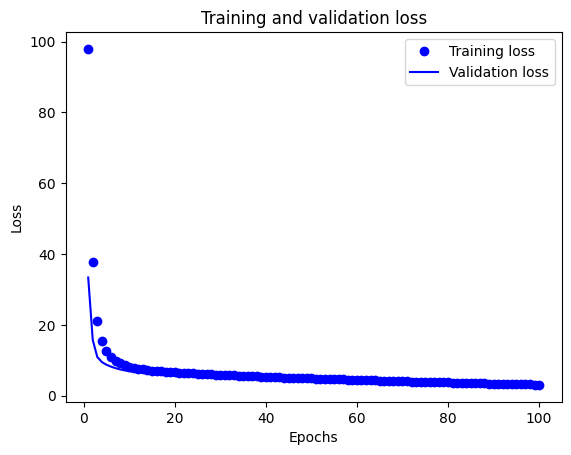

In [83]:
#plotting the training and validation loss
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [84]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [85]:
train_metric = 'accuracy'
val_metric = 'val_accuracy'

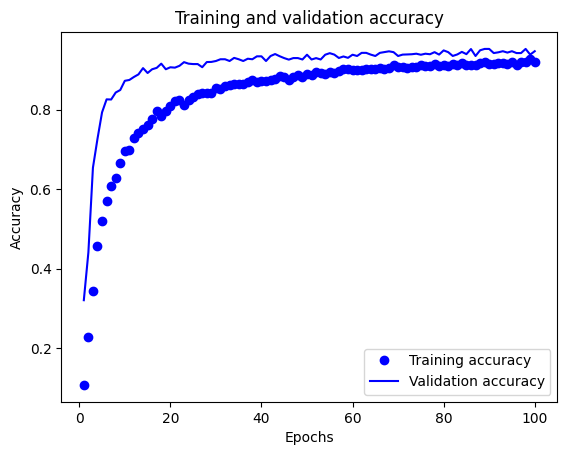

In [86]:
#plotting the training and validation accuracy
plt.clf()
acc = history.history[train_metric]
val_acc = history.history[val_metric]
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [87]:
model.evaluate(test_padded, y_test)

132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step - accuracy: 0.9471 - loss: 3.0199


[3.010782241821289, 0.9497630596160889]

In [88]:
y_test

array([8, 3, 8, ..., 3, 1, 9])

In [89]:
predictions = model.predict(test_padded)

132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step


In [90]:
predictions[3]

array([3.84206085e+01, 5.23424416e+01, 1.33954735e+01, 3.66380424e+01,
       2.32027359e+01, 1.68300724e+01, 8.16897125e+01, 1.21496601e+01,
       5.10993996e+01, 3.53060074e+01, 6.83914852e+00, 2.01821594e+01,
       3.64045054e-02, 0.00000000e+00, 0.00000000e+00, 6.29873419e+00,
       0.00000000e+00, 0.00000000e+00, 9.99648476e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       6.93192625e+00, 2.91886759e+00, 5.97619295e+00, 0.00000000e+00,
       5.64723730e+00, 2.43683720e+00, 2.53115952e-01, 1.80310857e+00,
       5.62511444e+00, 5.99360049e-01, 0.00000000e+00, 8.49369144e+00,
       8.43694806e-02, 8.05670977e-01, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 8.91295254e-01, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 3.84529901e+00, 0.00000000e+00,
       9.24263096e+00, 2.43536663e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [91]:
pred_list = []
for p in predictions:
   pred_list.append(p.argmax())

In [92]:
from sklearn.metrics import f1_score

In [93]:
f1_score(y_test, pred_list, average='micro')

0.9497630331753555

In [94]:
qa_df = pd.DataFrame({"text":X_test.content.to_numpy(), 
              "true_value":le.inverse_transform(y_test), 
              "predicted_value": le.inverse_transform(pred_list)})

In [95]:
dup_index = qa_df.duplicated()
qa_df = qa_df[~dup_index].copy()

In [96]:
for row in qa_df.to_dict(orient="records"):
    if row["predicted_value"]!= "generic feedback":
        print(row["text"])
        print("True value:",row["true_value"])
        print("Predicted value:", row["predicted_value"])
        print("***********************")

They literally scamming you. They show live prices of the tokens and when you sell they make it 10% less, but if you buy it they'll make 5% higher . It's a fraud , don't recommend anyone. And it's not coz if the market price change or any other factor, I had multiple such cases and every time on any exchange / market price was hig6and stable, but they make the swap/sell transaction with 10% lower rate.
True value: Transaction Fees/Speed
Predicted value: Transaction Fees/Speed
***********************
Doesn't support U.S Trades then pointless app
True value: Features/Functionality
Predicted value: Features/Functionality
***********************
Don't use their "CARDS" can't buy crypto with them or transfer back to a bank. When you buy your crypto they wait to process for the higher price.
True value: Transaction Fees/Speed
Predicted value: Transaction Fees/Speed
***********************
This is a scam app thank God I didn't deposited so much money Imagine an app crashing I wouldn't have ev

## Predicting against holdout set